In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
from scipy.fftpack import fft2, ifft2
from scipy.integrate import odeint
from scipy.sparse import eye, kron
from scipy.integrate import solve_ivp
from scipy.linalg import lu, solve_triangular
from matplotlib.animation import FuncAnimation
import time
from scipy.sparse.linalg import bicgstab, gmres

In [ ]:
L = 10
m = 64
n = m * m
I = eye(n)
grid = np.linspace(-L, L, m+1)
dx = grid[1] - grid[0]
#dx = 0.3125
e0 = np.zeros((n, 1))  # vector of zeros
e1 = np.ones((n, 1))   # vector of ones
e2 = np.copy(e1)    # copy the one vector
e4 = np.copy(e0)    # copy the zero vector

for j in range(1, m+1):
    e2[m*j-1] = 0  # overwrite every m^th value with zero
    e4[m*j-1] = 1  # overwirte every m^th value with one

# Shift to correct positions
e3 = np.zeros_like(e2)
e3[1:n] = e2[0:n-1]
e3[0] = e2[n-1]

e5 = np.zeros_like(e4)
e5[1:n] = e4[0:n-1]
e5[0] = e4[n-1]

# Place diagonal elements
diagonals = [e1.flatten(), e1.flatten(), e5.flatten(),
             e2.flatten(), -4 * e1.flatten(), e3.flatten(),
             e4.flatten(), e1.flatten(), e1.flatten()]
offsets = [-(n-m), -m, -m+1, -1, 0, 1, m-1, m, (n-m)]

matA = spdiags(diagonals, offsets, n, n).toarray()
#matA[0,0] = 2
A = matA/(dx**2)


e0 = np.zeros((n, 1))  # vector of zeros
e1 = np.ones((n, 1))   # vector of ones

diagonals = [e1.flatten(), -1*e1.flatten(), e0.flatten(),
             e1.flatten(), -1*e1.flatten()]
offsets = [-(n-m), -m, 0, m, (n-m)]

matA = spdiags(diagonals, offsets, n, n).toarray()
B = matA/(dx*2)

e0 = np.zeros((n, 1))  # vector of zeros
e1 = np.ones((n, 1))   # vector of ones
e2 = np.copy(e1)    # copy the one vector
e4 = np.copy(e0)    # copy the zero vector

for j in range(1, m+1):
    e2[m*j-1] = 0  # 111011101110
    e4[m*j-1] = 1  # 000100010001

# Shift to correct positions
e3 = np.zeros_like(e2)
e3[1:n] = e2[0:n-1]
e3[0] = e2[n-1] # 011101110111

e5 = np.zeros_like(e4)
e5[1:n] = e4[0:n-1]
e5[0] = e4[n-1] # 100010001000

# Place diagonal elements
diagonals = [e5.flatten(),
             -1* e2.flatten(), e0.flatten(), e3.flatten(),
             -1*e4.flatten()]
offsets = [-m+1, -1, 0, 1, m-1]

matA = spdiags(diagonals, offsets, n, n).toarray()
C = matA/(dx*2)
A[0,0] = 2/ (dx**2)

In [ ]:
# print(C.shape, B.shape, A.shape)

(4096, 4096) (4096, 4096) (4096, 4096)


In [ ]:
# Define parameters
tspan = np.arange(0, 4.5, 0.5)
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny

# Define spatial domain and initial conditions
x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)
dx = x2[1]-x2[0]
dy = y2[1]-y2[0]

# Define spectral k values
kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

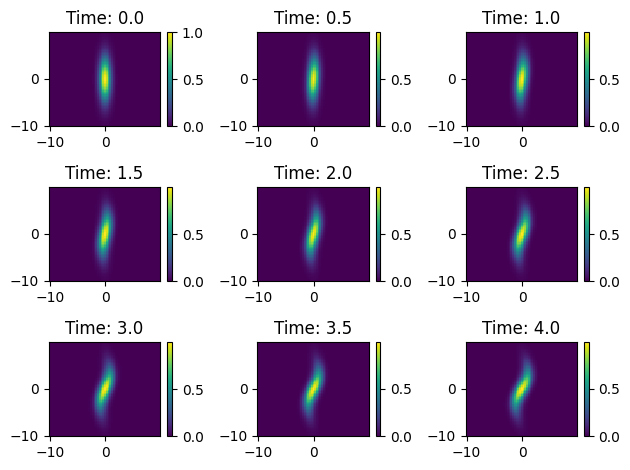

In [ ]:
# Define the ODE system
# w space domian 3D
# w2 space domian 2D
# wt fourier domain 3D
# wt2 fourier domain 2D

# Initialize as complex
w0 = np.exp(-X**2 - Y**2/20) + 1j * np.zeros((nx, ny))
w2 = w0.reshape(N)
# start_time = time.time()
def spc_rhs(t, w2):
    w = w2.reshape((nx, ny))
    wt = fft2(w)
    psit = -wt / K
    psi = np.real(ifft2(psit)).reshape(N)
    # [psi, w] = (B * psi)(C * w) - (C * psi)(B * w)
    # rhs = nu * K * w + (C * psi)(B * w) - (B * psi)(C * w)
    # rhs with w and psi
    rhs = nu * np.dot(A,w2) + np.dot(C,psi) * np.dot(B,w2) - np.dot(B,psi) * np.dot(C,w2)
    return rhs


# Solve the ODE and plot the results
wsol = solve_ivp(spc_rhs, [tspan[0], tspan[-1]], w2, t_eval=tspan, method='RK45')
A1 =np.real(wsol.y)
A1.shape
# end_time = time.time()
# elapsed_time = end_time - start_time
# print(f"Elapsed time: {elapsed_time:.2f} seconds")

# Visualization of results
for j, t in enumerate(tspan):
    plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, A1[:,j].reshape((nx, ny)), shading='auto')
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()

In [ ]:
print(A1[0,0])
print(A1[-1,-1])

2.506567475899953e-46
2.0841158240860071e-38


In [ ]:
# A/b
w0 = np.exp(-X**2 - Y**2/20)
w2 = w0.reshape(N)
# start_time = time.time()
def direct_solve_rhs(t, w2):
  psi = np.linalg.solve(A, w2)
  rhs = nu * np.dot(A,w2) + np.dot(C,psi) * np.dot(B,w2) - np.dot(B,psi) * np.dot(C,w2)
  return rhs

wsol = solve_ivp(direct_solve_rhs, [tspan[0], tspan[-1]], w2, t_eval=tspan, method='RK45')
A2 =np.real(wsol.y)
# end_time = time.time()
# elapsed_time = end_time - start_time
# print(f"Elapsed time: {elapsed_time:.2f} seconds")

In [ ]:
print(A2[0,0], A2[-1,-1])

2.506567475899953e-46 3.1276125436618907e-20


In [ ]:
# LU
# start_time = time.time()
def LU(t, w2):
  P, L, U = lu(A)
  Pb = np.dot(P, w2)
  y = solve_triangular(L, Pb, lower=True)
  x = solve_triangular(U, y)
  psi = x
  rhs = nu * np.dot(A,w2) + np.dot(C,psi) * np.dot(B,w2) - np.dot(B,psi) * np.dot(C,w2)
  return rhs

wsol = solve_ivp(LU, [tspan[0], tspan[-1]], w2, t_eval=tspan, method='RK45')
A3 =np.real(wsol.y)
# end_time = time.time()
# elapsed_time = end_time - start_time
# print(f"Elapsed time: {elapsed_time:.2f} seconds")

In [ ]:
print(A3[0,0], A3[-1,-1])

2.506567475899953e-46 3.12761254350041e-20


In [ ]:
# BICGSTAB
# Track residuals
residuals_bicgstab = []
w0 = np.exp(-X**2 - Y**2/20)
w2 = w0.reshape(N)
def bicgstab_callback(res):
#    residuals_bicgstab.append(res)

def bic(t, w2):
  psi_bicgstab, info_bicgstab = bicgstab(A, w2, tol=1e-6, maxiter=50, callback=bicgstab_callback)
  if info_bicgstab != 0:
        raise RuntimeError(f"BICGSTAB did not converge at time {t}. Info: {info_bicgstab}")
  rhs = nu * np.dot(A,w2) + np.dot(C,psi_bicgstab) * np.dot(B,w2) - np.dot(B,psi_bicgstab) * np.dot(C,w2)
  return rhs

# Solve using BICGSTAB
 start_bicgstab = time.time()
 wsol = solve_ivp(bic, [tspan[0], tspan[-1]], w2, t_eval=tspan, method='RK45')
 time_bicgstab = time.time() - start_bicgstab


In [ ]:
# GMRES
 x, flag, relres, iter = gmres(A, b, tol=tol, restart=restart, maxiter=maxit, M=M1, x0=x0)
 residuals_gmres = []
 def gmres_callback(res):
    residuals_gmres.append(res)

start_gmres = time.time()
def gm(t, w2):
  psi_gmres, info_gmres = gmres(A, w2, tol=1e-6, restart=50, maxiter=200, callback=gmres_callback)
  if info_gmres != 0:
        print(f"GMRES did not converge at time {t}, info: {info_gmres}")
  rhs = nu * np.dot(A,w2) + np.dot(C,psi_gmres) * np.dot(B,w2) - np.dot(B,psi_gmres) * np.dot(C,w2)
  return rhs

 Solve using GMRES
 wsol = solve_ivp(gm, [tspan[0], tspan[-1]], w2, t_eval=tspan, method='RK45')
 time_gmres = time.time() - start_gmres


In [ ]:
# def initialize_vorticity(case, X, Y, n_vortices=10):
#    if case == "opposite":
#        return np.exp(-((X - 5)**2 + Y**2/20)) - np.exp(-((X + 5)**2 + Y**2/20))
#    elif case == "same":
#        return np.exp(-((X - 5)**2 + Y**2/20)) + np.exp(-((X + 5)**2 + Y**2/20))
#    elif case == "colliding":
#        return (
#            np.exp(-((X + 5)**2 + (Y + 5)**2/20)) +  # Positive vortex
#            np.exp(-((X - 5)**2 + (Y - 5)**2/20)) -  # Positive vortex
#            np.exp(-((X - 5)**2 + (Y + 5)**2/20)) -  # Negative vortex
#            np.exp(-((X + 5)**2 + (Y - 5)**2/20))    # Negative vortex
#        )
#    elif case == "random":
#        np.random.seed(42)  # For reproducibility
#        omega = np.zeros_like(X)
#        for _ in range(n_vortices):
#            x0, y0 = np.random.uniform(-10, 10, 2)
#            A = np.random.uniform(-1, 1)
#            rx, ry = np.random.uniform(1, 3, 2)
#            omega += A * np.exp(-((X - x0)**2 / rx**2 + (Y - y0)**2/20 / ry**2))
#        return omega
#    else:
#        raise ValueError("Unknown case. Choose from 'opposite', 'same', 'colliding', or 'random'.")


In [ ]:
#case = "opposite"  # Change to "same", "colliding", or "random"
#w0 = initialize_vorticity(case, X, Y).flatten()

# Solve using your fastest solver (e.g., BICGSTAB or GMRES)
#wsol = solve_ivp(spc_rhs, [tspan[0], tspan[-1]], w0, t_eval=tspan, method='RK45')

# Reshape results for visualization
#A_case = wsol.y.reshape((nx, ny, len(tspan)))

# Set up the figure and axis
#fig, ax = plt.subplots(figsize=(8, 6))
#cax = ax.pcolor(X, Y, A_case[:, :, 0], shading="auto", cmap="coolwarm")
#fig.colorbar(cax, ax=ax)
#ax.set_title("Vorticity Dynamics")
#ax.set_xlabel("x")
#ax.set_ylabel("y")

# Animation update function
# def update(frame):
#    cax.set_array(A_case[:, :, frame].flatten())
#    ax.set_title(f"Time: {tspan[frame]:.1f}")
#    return cax,

# Create the animation
# ani = FuncAnimation(fig, update, frames=len(tspan), interval=200)

# Save as a movie
# ani.save("vorticity_dynamics.mp4", writer="ffmpeg", fps=10)

# plt.show()


/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


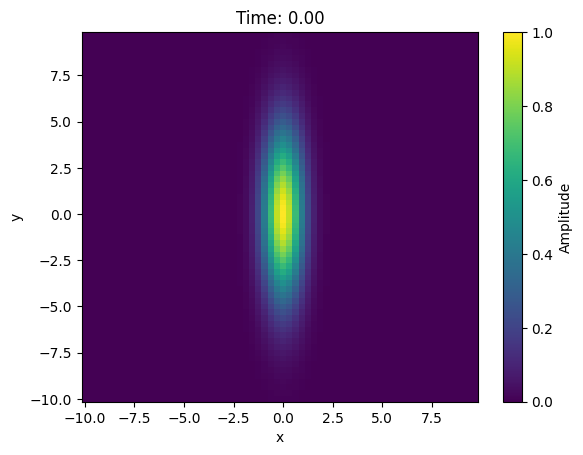

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Assuming A1, tspan, x, y, nx, ny are already defined
fig, ax = plt.subplots()

# Initial plot setup
cmap = ax.pcolormesh(x, y, A1[:, 0].reshape((nx, ny)), shading='auto', cmap='viridis')
cb = plt.colorbar(cmap, ax=ax)
cb.set_label('Amplitude')

ax.set_title(f'Time: {tspan[0]:.2f}')
ax.set_xlabel('x')
ax.set_ylabel('y')

# Function to update the plot
def update(frame):
    # Update the data in the pcolormesh object
    cmap.set_array(A1[:, frame].reshape((nx, ny)).ravel())
    ax.set_title(f'Time: {tspan[frame]:.2f}')
    return cmap, ax

# Create animation
ani = FuncAnimation(fig, update, frames=len(tspan), interval=200, blit=False)

# Explicitly store the animation in a variable
animation = ani

# Display the animation
plt.show()
